# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents  
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a yoga studio. Specifically, this report will be targeted to stakeholders interested in opening an **yoga stydio** in **Paris**, France.

There are many yoga studios in Paris, we will try to identify **locations close to the target population**. We would also prefer **locations as close as possible to the different transport lines** and we will take **into account the rental prices**, assuming the first condition is met. Knowledge of existing yoga studios will enable stakeholders to focus on areas that are **less occupied by competitors**.

We will use our data science powers to generate some of the most promising neighbourhoods based on these criteria. The benefits of each neighbourhood will then be clearly expressed so that stakeholders can choose the best possible final location.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of yoga studio
* the other establishments defining the profile of the boroughs
* the population repartition
* number of conveyance station
* rental price per m^2


We will use different benchmarks for the analysis, we will use rounding for the first sort, but we will use the grid of transportation stations for the final decision.



Following data sources will be needed to extract/generate the required information:
* number of yoga studio will be obtained from the **base Sirene V.03** using the API from the official website: **ODS** (Opendatasoft)
* information about conveyance will be obtained scrapping the official website: **iledefrance mobilités**
* information about borough will be obtained scrapping the official website: **data.gouv.fr**
* information about population repartition will be obtained scrapping the official website: **Insee site** (statistic site)
* number of location in every borough will be obtained using **Foursquare API**
* rental price per m2 will be obtained scrapping the data of the commercial website: https://www.geolocaux.com.

### Borough and yoga studios identification  

Let's check in Foursquare API which data about yoga studio we find. 
In pratice we can get only 100 venues pro request. There is much more as 100 restaurants, retails… per borough in Paris. I will so cut the Paris area with points each 500 m, in the aim to get the most  as possible of venues number. Of course, we will get a lot of duplicates which we will drop.

Let's first find the latitude & longitude of Paris city center and his boroughs.

In [5]:
import geopy.geocoders
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geopy.geocoders.options.default_user_agent = 'my_app/1'

address = 'Paris'

geolocator = Nominatim()
locationp = geolocator.geocode(address)
latitudep = locationp.latitude
longitudep = locationp.longitude
print('The geograpical coordinate of Paris City are {}, {}.'.format(latitudep, longitudep))


The geograpical coordinate of Paris City are 48.8566969, 2.3514616.


In [104]:
# import of the data about the boroughs:
import json
import requests

url_borough = 'https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c'
paris_borough= requests.get(url_borough).json()['features']
paris_geo=requests.get(url_borough).json()

In [7]:
import pandas as pd 

coordinates_b = []
borough = []
liste_paris_borough = []

for b in paris_borough :
    borough.append(b['properties']['l_aroff'])
    borough.append(b['properties']['c_arinsee'] - 100)
    coordinates_b = b['properties']['geom_x_y']
    borough.append(coordinates_b[0])
    borough.append(coordinates_b[1])
    borough.append(b['properties']['surface'])
    borough.append(b['geometry']['coordinates'])
    borough.append(b['properties']['c_arinsee'])
    liste_paris_borough.append(borough)
    borough = []
    data= []    


df_borough = pd.DataFrame(liste_paris_borough)
df_borough.columns = ['Name','postal code','latitude','longitude','surface','coordinates','code insee']
df_borough = df_borough.sort_values(by = 'postal code')
df_borough = df_borough.reset_index()
df_borough = df_borough.drop(['index'], axis = 1 )
df_borough.head()

Name  postal code   latitude  longitude       surface  \
0          Louvre        75001  48.862563   2.336443  1.824613e+06   
1          Bourse        75002  48.868279   2.342803  9.911537e+05   
2          Temple        75003  48.862872   2.360001  1.170883e+06   
3  Hôtel-de-Ville        75004  48.854341   2.357630  1.600586e+06   
4        Panthéon        75005  48.844443   2.350715  2.539375e+06   

                                         coordinates  code insee  
0  [[[2.328007329038849, 48.86991742140716], [2.3...       75101  
1  [[[2.351518483670822, 48.8644258050741], [2.35...       75102  
2  [[[2.363828096062925, 48.86750443060333], [2.3...       75103  
3  [[[2.368512371393433, 48.85573412813671], [2.3...       75104  
4  [[[2.364433128355796, 48.84614003688701], [2.3...       75105

Now let's create a grid of candidate areas, also spaced. To define the space to be crisscrossed we will take the longitudes and latitudes of the boroughs at the ends of the city to which we will add an additional distance to cover the entire space. Our exploration zones will be defined as circular zones with a radius of 500 meters, the centers of which will therefore be 1 km apart.


In [8]:
# define the points of the extremities of Paris
latmin = 0
lngmin = 0
latmax = 0
lngmax = 0

for i in range(df_borough.shape[0]):
    lat = float(df_borough.loc[i,'latitude'])
    lng = float(df_borough.loc[i,'longitude'])
    if latmin == 0 :
        latmin = lat
    elif lat < latmin:
        latmin = lat
    if latmax == 0 :
        latmax =lat
    elif lat > latmax:
        latmax = lat
    if lngmin == 0 :
        lngmin = lng
    elif lng < lngmin:
        lngmin = lng
    if lngmax == 0 :
        lngmax = lng
    elif lng > lngmax:
        lngmax = lng
print('latmin:',latmin,'lngmin:',lngmin,'latmax:',latmax,'lngmax:',lngmax)

latmin: 48.8283880317 lngmin: 2.26197078836 latmax: 48.892569268 lngmax: 2.42132490078


In [9]:
# define the dataframe of coordinates for the requests :
coordinates = []

# as we cannot use step with float value we adapt the start values:
latmin = int((round(latmin * 10000)))
lngmin = int((round(lngmin * 10000)))
latmax = int((round(latmax * 10000)))
lngmax = int((round(lngmax * 10000)))
compteur = 0
for x in range(latmin - 137,latmax + 133, 50):
    for y in range(lngmin - 58,lngmax + 70, 50):
        coordinates.append([compteur, x / 10000, y / 10000])
        compteur = compteur + 1
df_coor = pd.DataFrame(coordinates)
df_coor.columns = ['compteur','latitude','longitude']
print('number of explore points : ', df_coor.shape[0], '\n' )
df_coor.head()

number of explore points :  665 



compteur  latitude  longitude
0         0   48.8147     2.2562
1         1   48.8147     2.2612
2         2   48.8147     2.2662
3         3   48.8147     2.2712
4         4   48.8147     2.2762

Let's visualize the data we have so far: explore points and boroughs :

In [322]:
import folium 

paris_map_search=folium.Map(location=[latitudep, longitudep], zoom_start = 12)

paris_map_search.add_child(folium.GeoJson(paris_geo))

for lat, lng, label in zip(df_coor['latitude'],df_coor['longitude'],df_coor['compteur']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 1,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.6,
        parse_html = False).add_to(paris_map_search)  
    
paris_map_search

OK, we now have the coordinates of centers of areas to be evaluated, equally spaced. 

Let's now use Fourquare API to get the locations existing in theses areas

In [11]:
# Foursquare Identification data
CLIENT_ID = 'JSYJARHQ1E1WW0N5XELBVARTDBPLS1HD1GZBBOZBVW0X2DEO' # your Foursquare ID
CLIENT_SECRET = '0BCPHBI35NYZTOUASKWVUFZT0CVM1MTJCROHD44PYERA2LGN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JSYJARHQ1E1WW0N5XELBVARTDBPLS1HD1GZBBOZBVW0X2DEO
CLIENT_SECRET:0BCPHBI35NYZTOUASKWVUFZT0CVM1MTJCROHD44PYERA2LGN


In [12]:
def getcheckbyVenues(compteur,latitudes,longitudes,radius):
    
    data=[]
    for compteur,lat,lng in zip(compteur,latitudes,longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        listeloc=[]
        venue=[]
        for v in results:
            listeloc.append(v['venue']['location'])
            venue.append(v['venue']['name']) 
            venue.append(listeloc[0].get('lat'))
            venue.append(listeloc[0].get('lng'))
            venue.append(listeloc[0].get('postalCode'))
            venue.append(v['venue']['categories'][0]['name'])
            data.append(venue)
            listeloc=[]
            venue=[]
    df_data=pd.DataFrame(data)
    df_data.columns = [
                  'name', 
                  'latitude', 
                  'longitude', 
                  'postal code',
                  'Venue Category']
    
    return(df_data)

In [13]:
paris_venues_circle = getcheckbyVenues(
                                   compteur=df_coor['compteur'],
                                   latitudes=df_coor['latitude'],
                                   longitudes=df_coor['longitude'],
                                   radius=500
                                  )
paris_venues_circle.head()

name   latitude  longitude  \
0                            Issy Guinguette  48.818860   2.255304   
1                         Musee Rodin Meudon  48.814977   2.251409   
2  Tennis Club De Issy Les Moulineaux (TCIM)  48.816741   2.256400   
3                               190 - Fleury  48.812632   2.257906   
4                                      Tokyo  48.811966   2.258333   

  postal code     Venue Category  
0       92130  French Restaurant  
1        None         Art Museum  
2       92140     Tennis Stadium  
3        None        Bus Station  
4       92140   Sushi Restaurant

Let's clean the data and restrict the data on the Paris boroughs (postal code 75001-75020): 

In [14]:
paris_foursquare=paris_venues_circle.drop_duplicates()
paris_foursquare['postal code'].unique()

array(['92130', None, '92140', '92170', '92240', '92320', '92120',
       '92000', '94110', '94250', '75014', '75013', '94270', '94200',
       '94762', '94140', '94220', '94700', '9210', '91240', '94410',
       '92100', '92230', '75015', '75017', '06000', '73013', '75012',
       '54000', '75005', '75016', '75116', '75006', 'Paris', '94160',
       '92015', '75007', '94000', '75106', '71015', '75000', '750076',
       '75004', '75010', '75011', '75020', '94300', '74015', '75002',
       '76005', '75001', '93100', '01000', '75003', '75 011', '75058',
       '75008', '93170', '76116', '76008', '75018', '75009', '93541',
       '75019', '92200', 'France', '75008\u200e', '77164', '93260',
       '92800', '75 009', '93310', '92081', '92300', '93500', '93230',
       '91000', '92400', '92150', '92110', '93300', '95200', '93000',
       '93400', '93', '93200', '9300', '92250', '92270', '92600', '93210',
       '48120', '93324', '93013'], dtype=object)

In [15]:
paris_foursquare = paris_foursquare.replace('93500 Pantin','93500')
paris_foursquare = paris_foursquare.replace('75008\u200e','75008')
paris_foursquare = paris_foursquare.replace('75 009','75009')
paris_foursquare = paris_foursquare.replace('750076','75006')
paris_foursquare = paris_foursquare.replace('75 011','75011')
paris_foursquare = paris_foursquare.replace('92250\u200e','92250')
paris_foursquare = paris_foursquare.dropna(subset=['postal code'],axis=0)
paris_foursquare = paris_foursquare[ paris_foursquare['postal code'] != 'France'] 
paris_foursquare = paris_foursquare[ paris_foursquare['postal code'] != 'Paris'] 
paris_foursquare['postal code'] = paris_foursquare['postal code'].astype('int64')
paris_foursquare = paris_foursquare[paris_foursquare['postal code']>=75000]
paris_foursquare = paris_foursquare[paris_foursquare['postal code']<=75020]
paris_foursquare = paris_foursquare.reset_index()
paris_foursquare = paris_foursquare.drop(['index'], axis = 1)
paris_foursquare.head()

name   latitude  longitude  \
0  Parc de la Cité Internationale Universitaire  48.818503   2.337438   
1                             Porte de Gentilly  48.816595   2.343810   
2                                Stade Charléty  48.818486   2.346665   
3                                Parc Kellerman  48.818507   2.355537   
4     Ibis Styles Avenue Meteor porte d’ Italie  48.817415   2.359611   

   postal code Venue Category  
0        75014           Park  
1        75013          Plaza  
2        75013        Stadium  
3        75013           Park  
4        75013          Hotel

In [121]:
# search of the yoga studio in the results:
paris_yogaF=paris_foursquare[paris_foursquare['Venue Category']=='Yoga Studio']
paris_yogaF=paris_yogaF.reset_index()
paris_yogaF=paris_yogaF.drop(['index'],axis = 1)
print('number of yoga studio find with the Foursquare API:',paris_yogaF.shape[0])
paris_yogaF.head()

number of yoga studio find with the Foursquare API: 7


name   latitude  longitude  postal code Venue Category
0  Yoga Garden Rive Gauche  48.840183   2.333474        75014    Yoga Studio
1    Studio Big Apple Yoga  48.865586   2.348852        75002    Yoga Studio
2          The YogaFactory  48.863301   2.366017        75003    Yoga Studio
3      Ashtanga Yoga Paris  48.865272   2.373232        75011    Yoga Studio
4              Bikram Yoga  48.872702   2.342586        75009    Yoga Studio

It is missing yoga studios for Paris in the Foursquare database. It is why we will complete these venues with another database "Base Sirene V3" :

In [115]:
url_sirene = 'https://public.opendatasoft.com/api/records/1.0/search/?q=yoga&dataset=sirene_v3&rows=400&sort=datederniertraitementetablissement&facet=statutdiffusionetablissement&facet=trancheeffectifsetablissement&facet=libellecommuneetablissement&facet=etatadministratifetablissement&facet=nomenclatureactiviteprincipaleetablissement&facet=caractereemployeuretablissement&facet=departementetablissement&facet=regionetablissement&facet=sectionetablissement&facet=classeetablissement&facet=categorieentreprise&facet=sectionunitelegale&facet=classeunitelegale&facet=naturejuridiqueunitelegale&refine.departementetablissement=PARIS'
results_siren = requests.get(url_sirene).json()['records']
siren = []
fields = []
data_siren = []
for v in results_siren:
    fields.append(v['fields'])
    siren.append(fields[0].get('denominationunitelegale'))
    siren.append(fields[0].get('denominationusuelle1unitelegale'))
    siren.append(fields[0].get('geolocetablissement')[0])
    siren.append(fields[0].get('geolocetablissement')[1])
    siren.append(fields[0].get('codepostaletablissement'))
    siren.append(fields[0].get('divisionunitelegale'))
    siren.append(fields[0].get('classeetablissement'))
    siren.append(fields[0].get('etatadministratifetablissement'))
    data_siren.append(siren)
    fields = []
    siren = []
df_data_siren = pd.DataFrame(data_siren)
df_data_siren.columns = [
                  'name',
                  'Name1',
                  'latitude', 
                  'longitude', 
                  'postal code',
                  'Venue division',
                  'Venue Category',
                  'Venue activity']
print(df_data_siren.shape)
df_data_siren.head()

(364, 8)


name          Name1   latitude  longitude postal code  \
0                  None  YOGA DU COEUR  48.883267   2.367611       75010   
1        BABA YOGA CLUB           None  48.876942   2.352043       75010   
2                  None           None  48.855457   2.381729       75011   
3  JIVAMUKTI YOGA PARIS           None  48.852234   2.276352       75016   
4                  None           None  48.889154   2.310231       75017   

                                      Venue division  \
0                    Autres activites d'enseignement   
1                           Activites liees au sport   
2                    Autres activites d'enseignement   
3                    Autres activites d'enseignement   
4  Commerce de detail hors magasin, eventaires ou...   

                                      Venue Category Venue activity  
0  Enseignement de disciplines sportives et d'act...          Fermé  
1                  Gestion d'installations sportives          Actif  
2  Enseignement de disciplines sportives et d'act...          Fermé  
3  Enseignement de disciplines sportives et d'act...          Actif  
4             Vente a distance sur catalogue general          Fermé

In [116]:
# we drop all category of 'commerce'
indexcom = df_data_siren[df_data_siren['Venue Category'].str.contains('Commerce')].index
df_data_siren = df_data_siren.drop(index=indexcom,axis=0)

# we keep the categories related to a yoga studio
indexsport = df_data_siren[df_data_siren['Venue Category'].str.contains('sport')].index
indexens = df_data_siren[df_data_siren['Venue Category'].str.contains('enseignement')].index
indexform = df_data_siren[df_data_siren['Venue Category'].str.contains('formation')].index
indexcorp = df_data_siren[df_data_siren['Venue Category'].str.contains('corp')].index
indexsan = df_data_siren[df_data_siren['Venue Category'].str.contains('santé')].index
indexsoin = df_data_siren[df_data_siren['Venue Category'].str.contains('soin')].index
indexadh = df_data_siren[df_data_siren['Venue Category'].str.contains('adhesion')].index
liste_index = []
liste_index.append(indexsport)
liste_index.append(indexens)
liste_index.append(indexform)
liste_index.append(indexcorp)
liste_index.append(indexsan)
liste_index.append(indexsoin)
liste_index.append(indexadh)
liste_index_glob = []
for items in liste_index:
    for i in range(len(items)):
        liste_index_glob.append(items[i])
liste_index_glob.sort()    
df_data_siren = df_data_siren.loc[liste_index_glob,:]

# we keep only the yoga studio in activity :
df_data_siren = df_data_siren.loc[df_data_siren[df_data_siren['Venue activity']=='Actif'].index,:]
df_data_siren = df_data_siren.reset_index()

# we drop unnecessary columns :
df_data_siren = df_data_siren.drop(['index','Venue activity','Venue division','Name1'],axis=1)
df_data_siren = df_data_siren.dropna(subset=['name'],axis=0)

# we rename columns to concat the two dataframes of yoga studio :
df_data_siren['name'] = df_data_siren['name'].str.title()
df_data_siren.head()

name   latitude  longitude postal code  \
0        Baba Yoga Club  48.876942   2.352043       75010   
1  Jivamukti Yoga Paris  48.852234   2.276352       75016   
2             Naad Yoga  48.851118   2.384551       75011   
3            Hygge Sarl  48.891611   2.341992       75018   
4                Saurus  48.875736   2.388650       75019   

                                      Venue Category  
0                  Gestion d'installations sportives  
1  Enseignement de disciplines sportives et d'act...  
2                       Activites de clubs de sports  
3  Enseignement de disciplines sportives et d'act...  
4  Enseignement de disciplines sportives et d'act...

In [99]:
#  merge the 2 sources of yoga studios:
df_yoga = pd.concat([paris_yogaF, df_data_siren])
df_yoga = df_yoga.drop_duplicates(subset=['name'])
df_yoga['postal code'] = df_yoga['postal code'].astype('int64')
df_yoga = df_yoga[df_yoga['postal code'] != 75116] 
print('number of yoga studio:',df_yoga.shape[0])

number of yoga studio: 175


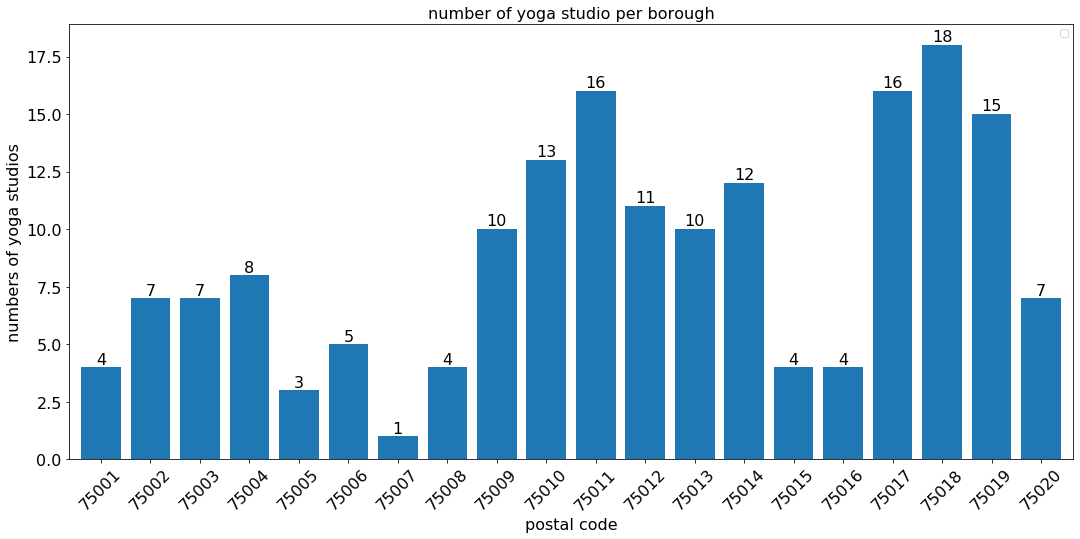

In [295]:
import matplotlib.pyplot as plt

df_yoga_count = df_yoga.groupby(['postal code']).count()
df_yoga_count = df_yoga_count[['name']]
df_yoga_count.columns=['yoga studios number']

ax=df_yoga_count.plot(kind='bar',figsize=(18, 8),fontsize=16,width=0.8)

ax.set_title("number of yoga studio per borough",size=16)
plt.legend(labels='')

ax.set_xlabel('postal code',size = 16)
ax.set_ylabel('numbers of yoga studios',size = 16)
plt.xticks(rotation = 45)
                    
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
            # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

            # Number of points between bar and label.
        space = 0.5
            # Vertical alignment for positive values
        va = 'bottom'

            # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

            # Create annotation
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            size=16,                    
            va=va)                     
                                            

# Call the function above.
add_value_labels(ax)

In [296]:
#calculation of yoga studio density, multiplied by 100,000 for readability purposes
density= []
yoga_density= []
for i in range(20): 
    yoga_density.append(df_borough.loc[i,'postal code'])
    yoga_density.append(df_yoga_count.loc[75001+i,'yoga studios number'] / df_borough.loc[i,'surface'] * 1000000)
    density.append(yoga_density)
    yoga_density=[]
df_yoga_density = pd.DataFrame(density)
df_yoga_density.columns =  ['postal code','density']

df_yoga_count = df_yoga_count.reset_index()
df_yoga_count = pd.merge(df_yoga_count,df_yoga_density, on = 'postal code')
df_yoga_count.head()

postal code  yoga studios number   density
0        75001                    4  2.192246
1        75002                    7  7.062476
2        75003                    7  5.978395
3        75004                    8  4.998171
4        75005                    3  1.181393

In [324]:
#  representation of yoga studios and boroughs: 

paris_map_yoga = folium.Map(location = [latitudep, longitudep], zoom_start = 12)

paris_map_yoga.choropleth(
    geo_data=paris_geo,
    fill_opacity=0.1, 
    line_opacity=0.4) 


for lat, lng, label in zip(df_yoga['latitude'],df_yoga['longitude'],df_yoga['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 2,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.7,
        parse_html = False).add_to(paris_map_yoga)  
    
paris_map_yoga

Looking good. So now we have all the yoga studio from Paris. We also know which yoga studios exactly are in  every borough.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new yoga studio!

## Methodology <a name="methodology"></a>

In this project, we will focus our efforts on identifying Paris districts that are particularly populated by susceptible customers but that meet the other criteria (rental price and proximity of means of transport). 

In first step we have collected the required **data: location and type (category) of venues in Paris**. We have also **identified yoga studios** (according to the Foursquare and Base Sirene V3.0 categorisation).

The second step of our analysis will be the analysis of the **distribution of yoga studios**. The first step will be to establish **profiles of the districts by analysing the type of structures** (monuments, restaurants...) that they host as well as the **distribution of their population** (age and professional categories). This will enable us to make a first choice of districts. 
The third step will consist in adding the following criteria:  **the transport offer and the annual rental price per m^ 2 of commercial premises** . These last criteria will allow us to refine our selection to the subway station.


## Analysis <a name="analysis"></a>

we see on the previous map that the distribution of yoga studios by boroughs is **not homogeneous**.
Let us try to understand the reason for this heterogeneity. First, let's analyze the **distribution of the other locations in the boroughs** (data from Foursquare):

In [24]:
df_onehot = pd.get_dummies(paris_foursquare[['Venue Category']], prefix="", prefix_sep="")
df_pc = paris_foursquare[['postal code']]
df_onehot = pd.concat([df_pc,df_onehot],axis=1)
df_onehot = df_onehot[ df_onehot['postal code']>75000]
df_onehot.head()

postal code  Accessories Store  Afghan Restaurant  African Restaurant  \
0        75014                  0                  0                   0   
1        75013                  0                  0                   0   
2        75013                  0                  0                   0   
3        75013                  0                  0                   0   
4        75013                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Antique Shop  Aquarium  \
0                    0                    0             0         0   
1                    0                    0             0         0   
2                    0                    0             0         0   
3                    0                    0             0         0   
4                    0                    0             0         0   

   Arepa Restaurant  Argentinian Restaurant  ...  Watch Shop  Water Park  \
0                 0                       0  ...           0           0   
1                 0                       0  ...           0           0   
2                 0                       0  ...           0           0   
3                 0                       0  ...           0           0   
4                 0                       0  ...           0           0   

   Waterfront  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0           0         0          0            0              0            0   
1           0         0          0            0              0            0   
2           0         0          0            0              0            0   
3           0         0          0            0              0            0   
4           0         0          0            0              0            0   

   Zoo  Zoo Exhibit  
0    0            0  
1    0            0  
2    0            0  
3    0            0  
4    0            0  

[5 rows x 359 columns]

In [25]:
df_grouped = df_onehot.groupby('postal code').mean().reset_index()
df_grouped.head()

postal code  Accessories Store  Afghan Restaurant  African Restaurant  \
0        75001           0.006579                0.0            0.000000   
1        75002           0.000000                0.0            0.000000   
2        75003           0.000000                0.0            0.005025   
3        75004           0.000000                0.0            0.000000   
4        75005           0.000000                0.0            0.002755   

   Alsatian Restaurant  American Restaurant  Antique Shop  Aquarium  \
0             0.000000                  0.0           0.0       0.0   
1             0.000000                  0.0           0.0       0.0   
2             0.000000                  0.0           0.0       0.0   
3             0.004202                  0.0           0.0       0.0   
4             0.000000                  0.0           0.0       0.0   

   Arepa Restaurant  Argentinian Restaurant  ...  Watch Shop  Water Park  \
0               0.0                0.000000  ...         0.0         0.0   
1               0.0                0.000000  ...         0.0         0.0   
2               0.0                0.005025  ...         0.0         0.0   
3               0.0                0.000000  ...         0.0         0.0   
4               0.0                0.000000  ...         0.0         0.0   

   Waterfront  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0    0.000000  0.019737   0.003289          0.0       0.003289     0.000000   
1    0.000000  0.035503   0.005917          0.0       0.011834     0.005917   
2    0.000000  0.025126   0.010050          0.0       0.000000     0.005025   
3    0.004202  0.016807   0.004202          0.0       0.000000     0.000000   
4    0.000000  0.013774   0.002755          0.0       0.000000     0.000000   

        Zoo  Zoo Exhibit  
0  0.000000     0.000000  
1  0.000000     0.000000  
2  0.000000     0.000000  
3  0.000000     0.000000  
4  0.002755     0.008264  

[5 rows x 359 columns]

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
import numpy as np 

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postal code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
data_venues_sorted = pd.DataFrame(columns=columns)
data_venues_sorted['postal code'] = df_grouped['postal code']

for ind in np.arange(df_grouped.shape[0]):
    data_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

data_venues_sorted.head()

postal code 1st Most Common Venue 2nd Most Common Venue  \
0        75001     French Restaurant                 Hotel   
1        75002     French Restaurant                 Hotel   
2        75003     French Restaurant           Art Gallery   
3        75004     French Restaurant    Italian Restaurant   
4        75005     French Restaurant                 Hotel   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0   Japanese Restaurant                  Café    Italian Restaurant   
1          Cocktail Bar    Italian Restaurant              Wine Bar   
2           Coffee Shop                 Hotel          Cocktail Bar   
3                 Plaza        Ice Cream Shop                 Hotel   
4                   Bar                  Café    Italian Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                 Plaza        Clothing Store                   Bar   
1                Bakery   Japanese Restaurant                   Bar   
2                Bakery   Japanese Restaurant                  Café   
3        Clothing Store                Bakery           Coffee Shop   
4                Bakery                 Plaza                Bistro   

  9th Most Common Venue 10th Most Common Venue  
0           Coffee Shop               Tea Room  
1                Bistro            Pizza Place  
2            Restaurant               Wine Bar  
3        Cosmetics Shop     Seafood Restaurant  
4   Indie Movie Theater            Coffee Shop

In [36]:
df_grouped_clustering = df_grouped.drop(columns=['postal code'])
df_grouped_clustering.head()

Accessories Store  Afghan Restaurant  African Restaurant  \
0           0.006579                0.0            0.000000   
1           0.000000                0.0            0.000000   
2           0.000000                0.0            0.005025   
3           0.000000                0.0            0.000000   
4           0.000000                0.0            0.002755   

   Alsatian Restaurant  American Restaurant  Antique Shop  Aquarium  \
0             0.000000                  0.0           0.0       0.0   
1             0.000000                  0.0           0.0       0.0   
2             0.000000                  0.0           0.0       0.0   
3             0.004202                  0.0           0.0       0.0   
4             0.000000                  0.0           0.0       0.0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  ...  Watch Shop  \
0               0.0                0.000000     0.000000  ...         0.0   
1               0.0                0.000000     0.005917  ...         0.0   
2               0.0                0.005025     0.045226  ...         0.0   
3               0.0                0.000000     0.021008  ...         0.0   
4               0.0                0.000000     0.000000  ...         0.0   

   Water Park  Waterfront  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0         0.0    0.000000  0.019737   0.003289          0.0       0.003289   
1         0.0    0.000000  0.035503   0.005917          0.0       0.011834   
2         0.0    0.000000  0.025126   0.010050          0.0       0.000000   
3         0.0    0.004202  0.016807   0.004202          0.0       0.000000   
4         0.0    0.000000  0.013774   0.002755          0.0       0.000000   

   Yoga Studio       Zoo  Zoo Exhibit  
0     0.000000  0.000000     0.000000  
1     0.005917  0.000000     0.000000  
2     0.005025  0.000000     0.000000  
3     0.000000  0.000000     0.000000  
4     0.000000  0.002755     0.008264  

[5 rows x 358 columns]

In [31]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k,random_state=0,n_init=30,max_iter=500)
    km = km.fit(df_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

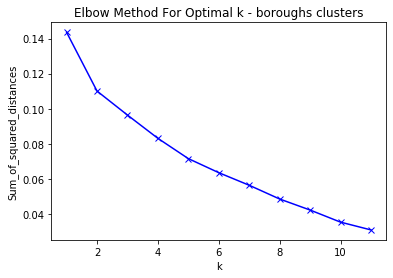

In [32]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - boroughs clusters')
plt.show()

In [33]:
# set number of clusters
kclusters = 2

# run k-means clusterin
kmeans = KMeans(n_clusters=kclusters, random_state=0,n_init=50,max_iter=500).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
      dtype=int32)

In [39]:
# add clustering labels
data_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# add boroughs latitudes and longitudes
df_merged = pd.merge(data_venues_sorted,df_borough[['postal code','latitude','longitude','code insee']], on = 'postal code' )
df_merged['latitude'] = df_merged['latitude'].astype('float64')
df_merged['longitude'] = df_merged['longitude'].astype('float64')
df_merged.head()

Cluster Labels  postal code 1st Most Common Venue 2nd Most Common Venue  \
0               0        75001     French Restaurant                 Hotel   
1               1        75002     French Restaurant                 Hotel   
2               1        75003     French Restaurant           Art Gallery   
3               0        75004     French Restaurant    Italian Restaurant   
4               0        75005     French Restaurant                 Hotel   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0   Japanese Restaurant                  Café    Italian Restaurant   
1          Cocktail Bar    Italian Restaurant              Wine Bar   
2           Coffee Shop                 Hotel          Cocktail Bar   
3                 Plaza        Ice Cream Shop                 Hotel   
4                   Bar                  Café    Italian Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                 Plaza        Clothing Store                   Bar   
1                Bakery   Japanese Restaurant                   Bar   
2                Bakery   Japanese Restaurant                  Café   
3        Clothing Store                Bakery           Coffee Shop   
4                Bakery                 Plaza                Bistro   

  9th Most Common Venue 10th Most Common Venue   latitude  longitude  \
0           Coffee Shop               Tea Room  48.862563   2.336443   
1                Bistro            Pizza Place  48.868279   2.342803   
2            Restaurant               Wine Bar  48.862872   2.360001   
3        Cosmetics Shop     Seafood Restaurant  48.854341   2.357630   
4   Indie Movie Theater            Coffee Shop  48.844443   2.350715   

   code insee  
0       75101  
1       75102  
2       75103  
3       75104  
4       75105

In [41]:
# represent boroughs clusters and yoga studios : 
map_clusters_borough = folium.Map(location=[latitudep, longitudep], zoom_start=12)

map_clusters_borough.choropleth(
    geo_data=paris_geo,
    fill_opacity=0.5, 
    line_opacity=0.4,
    data=df_merged,
    columns=['code insee','Cluster Labels'],
    key_on='feature.properties.c_arinsee',
    fill_color='YlOrRd', 
    legend_name='Cluster Paris')   
    
for lat, lng, label in zip(df_yoga['latitude'],df_yoga['longitude'],df_yoga['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 2,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_clusters_borough)      
    
map_clusters_borough

In [320]:
# show cluster 0 data : 
df_yoga_count = df_yoga_count.reset_index()
Cluster0 = pd.merge(df_yoga_count,df_merged[df_merged['Cluster Labels'] == 0],on = 'postal code')
Cluster0 = Cluster0.drop(['latitude','longitude','code insee'], axis = 1)
Cluster0.head()

index  postal code  yoga studios number   density  Cluster Labels  \
0      0        75001                    4  2.192246               0   
1      3        75004                    8  4.998171               0   
2      4        75005                    3  1.181393               0   
3      5        75006                    5  2.322238               0   
4      6        75007                    1  0.244495               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     French Restaurant                 Hotel   Japanese Restaurant   
1     French Restaurant    Italian Restaurant                 Plaza   
2     French Restaurant                 Hotel                   Bar   
3     French Restaurant                 Hotel                  Café   
4     French Restaurant                 Hotel    Italian Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                  Café    Italian Restaurant                 Plaza   
1        Ice Cream Shop                 Hotel        Clothing Store   
2                  Café    Italian Restaurant                Bakery   
3    Italian Restaurant   Japanese Restaurant        Chocolate Shop   
4                  Café                 Plaza           Coffee Shop   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Clothing Store                   Bar           Coffee Shop   
1                Bakery           Coffee Shop        Cosmetics Shop   
2                 Plaza                Bistro   Indie Movie Theater   
3                Bistro                Bakery              Wine Bar   
4                Bistro                Bakery            Restaurant   

  10th Most Common Venue  
0               Tea Room  
1     Seafood Restaurant  
2            Coffee Shop  
3               Creperie  
4    Japanese Restaurant

In [321]:
# show cluster 1 data : 
Cluster1 = pd.merge(df_yoga_count,df_merged[df_merged['Cluster Labels'] == 1],on = 'postal code')
Cluster1 = Cluster1.drop(['latitude','longitude','code insee'], axis = 1)
Cluster1.head()

index  postal code  yoga studios number   density  Cluster Labels  \
0      1        75002                    7  7.062476               1   
1      2        75003                    7  5.978395               1   
2      9        75010                   13  4.495564               1   
3     10        75011                   16  4.365095               1   
4     11        75012                   11  0.674235               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     French Restaurant                 Hotel          Cocktail Bar   
1     French Restaurant           Art Gallery           Coffee Shop   
2     French Restaurant                 Hotel                   Bar   
3                   Bar     French Restaurant                 Hotel   
4     French Restaurant                 Hotel                   Bar   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Italian Restaurant              Wine Bar                Bakery   
1                 Hotel          Cocktail Bar                Bakery   
2     Indian Restaurant    Italian Restaurant           Coffee Shop   
3                Bistro            Restaurant                  Café   
4   Japanese Restaurant    Italian Restaurant                Bakery   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0    Japanese Restaurant                   Bar                Bistro   
1    Japanese Restaurant                  Café            Restaurant   
2                 Bistro                Bakery                  Café   
3  Vietnamese Restaurant              Wine Bar    Italian Restaurant   
4         Sandwich Place           Supermarket           Pizza Place   

     10th Most Common Venue  
0               Pizza Place  
1                  Wine Bar  
2       Japanese Restaurant  
3           Thai Restaurant  
4  Bike Rental / Bike Share

We observe that the districts of the cluster shown in red (Cluster 1) have more yoga studios overall than those of the Yellow Cluster. Let's analyse the difference of these 2 Clusters. 
We notice first of all for Cluster 0 (yellow) that the 1st most frequent place are the French restaurants and the 2nd most frequent place (except for one district) are the hotels. If for Cluster 1 (red), French restaurants are among the 1st most frequent places, it is the same for bars and hotels. Now let's look at the numbers precisely: 

In [45]:
# analysis hotels, french restaurants and bars densitys for the Cluster 0
data_cluster0 = pd.merge(df_grouped[['postal code','Hotel']],Cluster0[['postal code']], on = 'postal code')
data_cluster0 = pd.merge(data_cluster0,df_grouped[['postal code','French Restaurant']], on = 'postal code')
data_cluster0 =  pd.merge(data_cluster0,df_grouped[['postal code','Bar']], on = 'postal code')
data_cluster0 = data_cluster0.rename(columns={'French Restaurant':'Fr_Restaurant'})

print('CLUSTER 0:')
print('density Hotel             min:',round(data_cluster0.Hotel.min(),3),
      '- mean:',round(data_cluster0.Hotel.mean(),3),
      '- max:',round(data_cluster0.Hotel.max(),3))
print('density French Restaurant min:',round(data_cluster0.Fr_Restaurant.min(),3),
      '- mean:',round(data_cluster0.Fr_Restaurant.mean(),3),
      '- max:',round(data_cluster0.Fr_Restaurant.max(),3))
print('density Bar               min:',round(data_cluster0.Bar.min(),3),
      '- mean:',round(data_cluster0.Bar.mean(),3),
      '- max:',round(data_cluster0.Bar.max(),3))

CLUSTER 0:
density Hotel             min: 0.036 - mean: 0.095 - max: 0.156
density French Restaurant min: 0.121 - mean: 0.151 - max: 0.212
density Bar               min: 0.003 - mean: 0.021 - max: 0.045


In [46]:
# analysis hotels, french restaurants and bars densitys for the Cluster 0
data_cluster1 = pd.merge(df_grouped[['postal code','Hotel']], Cluster1[['postal code']], on = 'postal code')
data_cluster1 = pd.merge(data_cluster1, df_grouped[['postal code','French Restaurant']], on = 'postal code')
data_cluster1 =  pd.merge(data_cluster1, df_grouped[['postal code','Bar']], on = 'postal code')
data_cluster1 = data_cluster1.rename(columns = {'French Restaurant':'Fr_Restaurant'})

print('CLUSTER 1: ')

print('density Hotel             min:',round(data_cluster1.Hotel.min(),3),
      '- mean:',round(data_cluster1.Hotel.mean(),3),
      '- max:',round(data_cluster1.Hotel.max(),3))
print('density French Restaurant min:',round(data_cluster1.Fr_Restaurant.min(),3),
      '- mean:',round(data_cluster1.Fr_Restaurant.mean(),3),
      '- max:',round(data_cluster1.Fr_Restaurant.max(),3))
print('density Bar               min:',round(data_cluster1.Bar.min(),3),
      '- mean:',round(data_cluster1.Bar.mean(),3),
      '- max:',round(data_cluster1.Bar.max(),3))


CLUSTER 1: 
density Hotel             min: 0.033 - mean: 0.055 - max: 0.086
density French Restaurant min: 0.075 - mean: 0.103 - max: 0.156
density Bar               min: 0.015 - mean: 0.056 - max: 0.109


the average densities of the different elements show us that cluster 0 (yellow) is made up of about **twice as many hotels, 1.5 times as many French restaurants and 1 third of the number of bars located in cluster 1**. Adding to this the general knowledge of the districts of 
In Paris, we can deduce that **cluster 0 includes tourist districts** with many French hotels and restaurants to welcome them. We can find the most famous tourist monuments (the Eiffel Tower is in the 7th district, the Champs Elysée in the 8th, ...) as well as places famous for their luxury shops (Place Vendome in the 8th).  The greater presence of bars in **cluster 1 suggests that the average working population is more present in its districts**.

As the target customers of yoga studios are not tourists, we will test our hypothesis on cluster 1 by analyzing the **distribution of its population**. We will also try to deduce a correlation between the presence of yoga studios and particular segments of the population: 

In [304]:
#import data, source open data Insee : 
file = '/Users/clairelecam/Downloads/base-ic-evol-struct-pop-2015.xls'
df_pop = pd.read_excel(file,sheet_name='IRIS',header=4)

#filters only the Paris districts:
df_pop = df_pop[df_pop['Libellé commune ou ARM'].str.contains('Paris')]
df_pop = df_pop[df_pop['Libellé commune ou ARM'].str.contains('Arrondissement')]
df_pop.reset_index()

#drop unnecessary contents :
df_pop = df_pop.drop(['IRIS',
            'Région',
            'Département',
            'Unité urbaine',
            'Commune ou ARM',
            'TRIRIS',
            'Grand quartier',
            "Libellé de l'IRIS",
            "Type d'IRIS",
            "Modification de l'IRIS",
            "Label de l'IRIS"],axis = 1)
df_pop = df_pop.groupby('Libellé commune ou ARM').sum()
df_pop = df_pop.reset_index()
df_pop = df_pop.rename(columns = {'Libellé commune ou ARM':'postal code'})

# replace contents of 'postal code' like 'Paris 10e Arrondissement' to '75010':
for i in range(2,10):
    df_pop = df_pop.replace({'Paris {}e Arrondissement'.format(i):'7500{}'.format(i)})
for i in range(10,21):
    df_pop = df_pop.replace({'Paris {}e Arrondissement'.format(i):'750{}'.format(i)})
df_pop = df_pop.replace({'Paris 1er Arrondissement':'75001'})
df_pop = df_pop.sort_values(by = 'postal code')
df_pop['postal code'] = df_pop['postal code'].astype('int64')

df_pop.head()

postal code  Population en 2015 (princ)  Pop 0-2 ans en 2015 (princ)  \
10        75001                     16545.0                   397.309659   
12        75002                     20796.0                   596.079748   
13        75003                     35049.0                   931.179665   
14        75004                     27146.0                   618.191909   
15        75005                     59333.0                  1210.034006   

    Pop 3-5 ans en 2015 (princ)  Pop 6-10 ans en 2015 (princ)  \
10                   336.375459                    643.727320   
12                   546.887390                    789.621848   
13                   854.550060                   1277.314343   
14                   666.868944                   1010.327815   
15                  1299.773329                   2197.836908   

    Pop 11-17 ans en 2015 (princ)  Pop 18-24 ans en 2015 (princ)  \
10                     850.699109                    1604.526469   
12                     989.726212                    2223.838732   
13                    1685.714234                    3748.364762   
14                    1399.366830                    3049.676050   
15                    3482.395902                    9880.540729   

    Pop 25-39 ans en 2015 (princ)  Pop 40-54 ans en 2015 (princ)  \
10                    4241.469367                    3564.294818   
12                    7133.661730                    4442.644361   
13                   10837.657165                    7576.005383   
14                    7145.885935                    5508.174557   
15                   13548.494947                   10086.504399   

    Pop 55-64 ans en 2015 (princ)  ...  \
10                    1817.000450  ...   
12                    1971.204019  ...   
13                    3501.280136  ...   
14                    3099.676546  ...   
15                    6445.142560  ...   

    Pop 15 ans ou plus Femmes Prof. intermédiaires en 2015 (compl)  \
10                                        1026.544312                
12                                        1629.394734                
13                                        2628.075894                
14                                        1964.291748                
15                                        3872.527443                

    Pop 15 ans ou plus Femmes Employés en 2015 (compl)  \
10                                         945.016665    
12                                        1208.530860    
13                                        1947.747566    
14                                        1477.914059    
15                                        2854.106139    

    Pop 15 ans ou plus Femmes Ouvriers en 2015 (compl)  \
10                                         132.028644    
12                                         244.699979    
13                                         237.869547    
14                                         184.473337    
15                                         252.047048    

    Pop 15 ans ou plus Femmes Retraités en 2015 (compl)  \
10                                        1630.425541     
12                                        1130.805167     
13                                        2444.505193     
14                                        2538.611759     
15                                        6325.776916     

    Pop 15 ans ou plus Femmes Autres en 2015 (compl)  \
10                                       1331.345766   
12                                       1347.137762   
13                                       2745.554955   
14                                       2289.743188   
15                                       6274.434805   

    Pop Français en 2015 (princ)  Pop Etrangers en 2015 (princ)  \
10                  14325.912563                    2219.087437   
12                  17289.863518                    3506.136482   
13                  29562.286802                    5486.713198   
14    

In [305]:
# calculation the repartition of population in percentage: 
pop = [] 
pop0_14 = []
pop15_29 = []
pop30_44 = []
pop45_59 = []
pop60_74 = []
pop75 = []
pop_director = []
pop_prof_highlevel = []
pop_prof_midlevel = []
pop_employees= [] 
pop_labourers = []
pop_pensioners = []
pop_others = []
postal_code = []

for i in range(20):
    pop.append(df_pop.loc[i,'Population en 2015 (princ)'])
    pop0_14.append(df_pop.loc[i,'Pop 0-14 ans en 2015 (princ)'] / df_pop.loc[i,'Population en 2015 (princ)'])
    pop15_29.append(df_pop.loc[i,'Pop 15-29 ans en 2015 (princ)'] / df_pop.loc[i,'Population en 2015 (princ)'])
    pop30_44.append(df_pop.loc[i,'Pop 30-44 ans en 2015 (princ)'] / df_pop.loc[i,'Population en 2015 (princ)'])
    pop45_59.append(df_pop.loc[i,'Pop 45-59 ans en 2015 (princ)'] / df_pop.loc[i,'Population en 2015 (princ)'])
    pop60_74.append(df_pop.loc[i,'Pop 60-74 ans en 2015 (princ)'] / df_pop.loc[i,'Population en 2015 (princ)'])
    pop75.append(df_pop.loc[i,'Pop 75 ans ou plus en 2015 (princ)'] / df_pop.loc[i,'Population en 2015 (princ)'])
    pop_director.append(df_pop.loc[i,'Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    pop_prof_highlevel.append(df_pop.loc[i,'Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    pop_prof_midlevel.append(df_pop.loc[i,'Pop 15 ans ou plus Prof. intermédiaires en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    pop_employees.append(df_pop.loc[i,'Pop 15 ans ou plus Employés en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    pop_labourers.append(df_pop.loc[i,'Pop 15 ans ou plus Ouvriers en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    pop_pensioners.append(df_pop.loc[i,'Pop 15 ans ou plus Retraités en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    pop_others.append(df_pop.loc[i,'Pop 15 ans ou plus Autres en 2015 (compl)'] / df_pop.loc[i,'Pop 15 ans ou plus en 2015 (compl)'])
    postal_code.append(df_pop.loc[i,'postal code'])
    
pop={'postal code' : postal_code,
     'pop' : pop,
     'pop0_14' : pop0_14,
     'pop15_29' : pop15_29,
     'pop30_44' : pop30_44,
     'pop45_59' : pop45_59,
     'pop60_74' : pop60_74,
     'pop75' : pop75,
     'pop_director' : pop_director,
     'pop_prof_highlevel' : pop_prof_highlevel , 
     'pop_prof_midlevel' : pop_prof_midlevel,
     'pop_employees' : pop_employees,
     'pop_labourers' : pop_labourers,
     'pop_pensioners' : pop_pensioners,
     'pop_others' : pop_others  
    }
rep_pop = pd.DataFrame(pop) 
rep_pop = pd.merge(data_venues_sorted[['Cluster Labels','postal code']],rep_pop,on = 'postal code')
rep_pop.head()                
        

Cluster Labels  postal code      pop   pop0_14  pop15_29  pop30_44  \
0               0        75001  16545.0  0.113220  0.212606  0.235465   
1               1        75002  20796.0  0.122735  0.260713  0.288026   
2               1        75003  35049.0  0.116228  0.249336  0.268540   
3               0        75004  27146.0  0.112404  0.246361  0.223394   
4               0        75005  59333.0  0.112681  0.293813  0.183342   

   pop45_59  pop60_74     pop75  pop_director  pop_prof_highlevel  \
0  0.198636  0.150788  0.089286      0.054863            0.325303   
1  0.183519  0.103301  0.041706      0.046469            0.390141   
2  0.185850  0.123571  0.056475      0.051316            0.361394   
3  0.189921  0.149485  0.078435      0.048689            0.330092   
4  0.167260  0.152684  0.090220      0.032559            0.326103   

   pop_prof_midlevel  pop_employees  pop_labourers  pop_pensioners  pop_others  
0           0.129212       0.102513       0.032909        0.198527    0.156464  
1           0.160978       0.112768       0.048240        0.111020    0.129876  
2           0.159823       0.101195       0.030875        0.142737    0.152538  
3           0.147230       0.106206       0.025714        0.178298    0.163654  
4           0.127205       0.082781       0.023448        0.200695    0.206943

In [306]:
# calculation of means per clusters : 
rep_pop_cluster = rep_pop.groupby('Cluster Labels').mean()
rep_pop_cluster = rep_pop_cluster.drop(['postal code','pop'],axis = 1)
rep_pop_sum = rep_pop.groupby('Cluster Labels').sum()
rep_pop_cluster = pd.concat([rep_pop_sum[['pop']],rep_pop_cluster],axis = 1)
rep_pop_cluster

pop   pop0_14  pop15_29  pop30_44  pop45_59  pop60_74  \
Cluster Labels                                                                
0               1004693.0  0.128293  0.244274  0.207133  0.181612  0.149799   
1               1201795.0  0.141683  0.233685  0.250178  0.185477  0.126743   

                   pop75  pop_director  pop_prof_highlevel  pop_prof_midlevel  \
Cluster Labels                                                                  
0               0.088889      0.045077            0.317560           0.127498   
1               0.062233      0.034400            0.292862           0.161754   

                pop_employees  pop_labourers  pop_pensioners  pop_others  
Cluster Labels                                                            
0                    0.103136       0.029248        0.192421    0.184684  
1                    0.133407       0.052990        0.165743    0.158690

The averages carried out by Cluster on population segments and activities show us that Cluster 0 (yellow) is made up of a population aged over 60 (22%) is higher than that of Cluster 1 (18%) while the active population aged between 30 and 59 (28%) is lower than that of Cluster 1 (33%).  Our hypothesis that neighbourhoods with many yoga studios correspond to those with a strong younger active population seems to be validated by these new data.


Before looking for clusters on the distribution of the population allowing us to decide on a few targeted districts for our decision. We are going to study the different existing correlations. For the sake of efficiency, we show only the proven correlations: 

In [307]:
#adding yoga studios number : 
df_pop = pd.merge(df_pop,df_yoga_count[['postal code','yoga studios number']],on = 'postal code')

The Pearson Correlation Coefficient is 0.5920474476944297  with a P-value of P = 0.00595616881781608


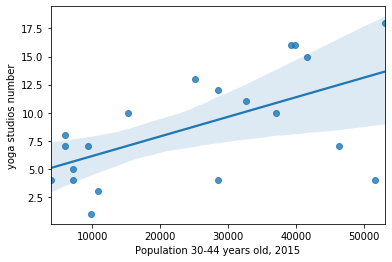

In [310]:
from scipy import stats
import seaborn as sns
pearson_coef, p_value = stats.pearsonr(df_pop['Pop 30-44 ans en 2015 (princ)'], df_pop['yoga studios number'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
sns.regplot(x = 'Pop 30-44 ans en 2015 (princ)',y = 'yoga studios number',data = df_pop)
plt.xlabel('Population 30-44 years old, 2015')
plt.show()

The Pearson Correlation Coefficient is 0.5576027822323161  with a P-value of P = 0.01063448169955478


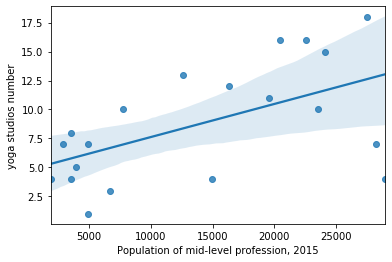

In [311]:
pearson_coef, p_value = stats.pearsonr(df_pop['Pop 15 ans ou plus Prof. intermédiaires en 2015 (compl)'], 
                                       df_pop['yoga studios number'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
sns.regplot(x = 'Pop 15 ans ou plus Prof. intermédiaires en 2015 (compl)',y = 'yoga studios number',data = df_pop)
plt.xlabel('Population of mid-level profession, 2015')
plt.show()

The Pearson Correlation Coefficient is 0.6093185660378773  with a P-value of P = 0.004346321306975396


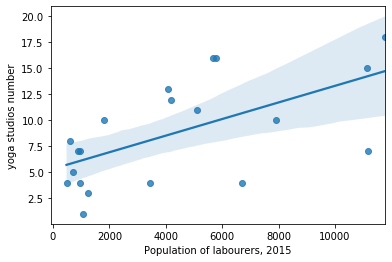

In [312]:
pearson_coef, p_value = stats.pearsonr(df_pop['Pop 15 ans ou plus Ouvriers en 2015 (compl)'], df_pop['yoga studios number'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
sns.regplot(x = 'Pop 15 ans ou plus Ouvriers en 2015 (compl)',y = 'yoga studios number',data = df_pop)
plt.xlabel('Population of labourers, 2015')
plt.show()

The Pearson Correlation Coefficient is 0.6093185660378773  with a P-value of P = 0.01392532743759539


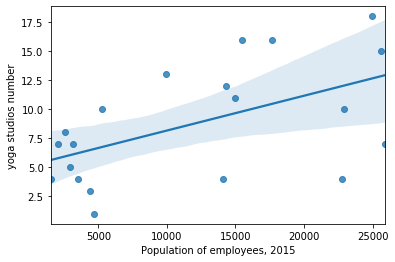

In [313]:
coef, p_value = stats.pearsonr(df_pop['Pop 15 ans ou plus Employés en 2015 (compl)'], df_pop['yoga studios number'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
sns.regplot(x = 'Pop 15 ans ou plus Employés en 2015 (compl)',y = 'yoga studios number',data = df_pop)
plt.xlabel('Population of employees, 2015')
plt.show()

We are now going to establish the clusters of the districts according to the 4 criteria having shown a correlation:
- population aged 30 to 44
- population with intermediate occupations
- population with an employee activity
- population with a blue-collar work


In [314]:
rep_pop_clustering=rep_pop[['pop30_44','pop_prof_midlevel','pop_employees','pop_labourers']]
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters = k,random_state = 0,n_init = 30,max_iter = 500)
    km = km.fit(rep_pop_clustering)
    Sum_of_squared_distances.append(km.inertia_)

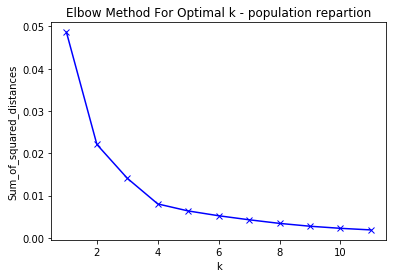

In [315]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - population repartion')
plt.show()

In [316]:
# set number of clusters
kclusters_all = 4

# run k-means clusterin
kmeans_all = KMeans(n_clusters=kclusters_all, random_state=0,n_init=50,max_iter=500).fit(rep_pop_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_all.labels_[0:20] 

array([1, 2, 2, 1, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 3, 1, 0, 0, 0],
      dtype=int32)

In [317]:
# add clustering labels
rep_pop_clustering.insert(0, 'Cluster Labels all', kmeans_all.labels_)

# add boroughs latitudes and longitudes
rep_pop_clustering=pd.concat([rep_pop[['postal code']],rep_pop_clustering],axis=1)
rep_pop_clustering = pd.merge(rep_pop_clustering ,df_borough[['postal code','latitude','longitude','code insee']], on = 'postal code' )
rep_pop_clustering['latitude'] = rep_pop_clustering['latitude'].astype('float64')
rep_pop_clustering['longitude'] = rep_pop_clustering['longitude'].astype('float64')

# add number and density of yoga studio
rep_pop_clustering = pd.merge(df_yoga_count,rep_pop_clustering,on = 'postal code' )
rep_pop_clustering = rep_pop_clustering.sort_values(by = 'Cluster Labels all')
rep_pop_clustering.head()

postal code  yoga studios number   density  Cluster Labels all  pop30_44  \
19        75020                    7  1.169894                   0  0.236288   
17        75018                   18  3.001976                   0  0.268725   
18        75019                   15  2.208269                   0  0.223916   
16        75017                   16  2.822450                   1  0.235832   
14        75015                    4  0.470866                   1  0.219390   

    pop_prof_midlevel  pop_employees  pop_labourers   latitude  longitude  \
19           0.171278       0.157325       0.067720  48.863461   2.401188   
17           0.163009       0.147757       0.069782  48.892569   2.348161   
18           0.157396       0.167725       0.072769  48.887076   2.384821   
16           0.142525       0.122776       0.040256  48.887327   2.306777   
14           0.142950       0.112444       0.033028  48.840085   2.292826   

    code insee  
19       75120  
17       75118  
18       75119  
16       75117  
14       75115

In [318]:
#mean pro clusters : 
rep_pop_clustering.groupby('Cluster Labels all').mean()

postal code  yoga studios number   density  pop30_44  \
Cluster Labels all                                                          
0                   75019.000000            13.333333  2.126713  0.242977   
1                   75010.857143             9.285714  2.099126  0.221325   
2                   75007.000000            10.600000  5.298452  0.269488   
3                   75008.400000             3.400000  1.004671  0.180884   

                    pop_prof_midlevel  pop_employees  pop_labourers  \
Cluster Labels all                                                    
0                            0.163895       0.157602       0.070090   
1                            0.143689       0.118518       0.036917   
2                            0.161360       0.112502       0.042053   
3                            0.110792       0.094044       0.023935   

                     latitude  longitude    code insee  
Cluster Labels all                                      
0                   48.881035   2.378057  75119.000000  
1                   48.848132   2.343402  75110.857143  
2                   48.868701   2.356210  75107.000000  
3                   48.856572   2.314065  75108.400000

In [201]:
# representation of repartition population cluster according the 4 decided criteria :  

map_clusters_pop_all = folium.Map(location=[latitudep, longitudep], zoom_start=12)

map_clusters_pop_all.choropleth(
    geo_data=paris_geo,
    fill_opacity=0.5, 
    line_opacity=0.4,
    data=rep_pop_clustering,
    columns=['code insee','Cluster Labels all'],
    key_on='feature.properties.c_arinsee',
    fill_color='RdBu', 
    legend_name='Cluster population Paris')   
    
for lat, lng, label in zip(df_yoga['latitude'],df_yoga['longitude'],df_yoga['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 2,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_clusters_pop_all)      
    
map_clusters_pop_all

The data indicate that **cluster 0 (in orange)** corresponds to the districts with **a large population (38%) of the 3 categories of activities** (intermediate occupations, employees, blue-collar workers) and more particularly with the **highest percentage of blue-collar workers**.It also has the **highest average number of yoga studios (13)** per borough.

**Cluster 2 (light blue)** corresponds to the districts with the **highest representation of the population aged 30-44(26%)** and a **predominance of intermediate occupations(16%)**.it also has the **highest average density of yoga studios(5,3)** per borough. 

**Cluster 1 (white)** is a grouping **similar to Cluster 2** with a **slight decrease** in the representation of the **population aged between 30 and 44 years(4%), intermediate professions(2%) and blue-collar activities(1%)**..It also has a density that is **half the highest density (2,1)** and has a **lower average number of studios (9)** per borough than the first two clusters.

**Cluster 3 (dark blue)** corresponds to the boroughs with the **lowest percentage of the population aged 30-44 (18%)** and with the **lowest proportion of the 3 categories of activities(22%)**.it has the **lowest average density(1)** and the **lowest average number of yoga studios(3)** per borough.

the presence of yoga studios is **positively correlated** to the four criteria studied and with greater certainty to the presence of the **population aged 30 to 44** with **blue-collar work**. the proportion of workers (max average 7%) being always lower than that of the age group (max average 26%) we propose to **privilege the criterion of the age of the population**. This allows us to classify the following clusters in this order: **2,0,1,3**. **Clusters 2 and 0 being already the most equipped in terms of yoga studios**, we propose to **focus on cluster 1**. Indeed, although **cluster 3** has the fewest yoga studios, we judge from the figures that it is **not sufficiently populated with potential customers unlike cluster 1**.The districts corresponding to Cluster 1 are as follows: 75001,75004, 75012 to 75015,75017.

In [63]:
# search for the postal code of the  stations via API from the coordinates
def def_arr(latitudes,longitudes,names):
    liste_arr=[]
    for latitude,longitude,name in zip(latitudes,longitudes,names):
        curl="https://api-adresse.data.gouv.fr/reverse/?lon={}&lat={}".format(longitude,latitude)
        results = requests.get(curl).json()['features']
        data=[]
        for v in results:
            data.append(name)
            data.append(v['properties']['postcode'])
            liste_arr.append(data)
    df_liste_arr = pd.DataFrame(liste_arr)
    df_liste_arr.columns = ['station name','postal code']
    return(df_liste_arr)

In [64]:
# import conveyance stations data : 
url_station='https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf-data-generalisee/download/?format=json&timezone=Europe/Berlin&lang=fr'
metro = requests.get(url_station).json()
station = []
station_metro = []
coordinates = []
for m in metro :
    station.append(m['fields']['label'])
    station.append(m['fields']['res_com'])
    coordinates=m['fields']['geo_point_2d']
    station.append(coordinates[0])
    station.append(coordinates[1])
    station_metro.append(station)
    station = []
    coordinates = []
df_metro= pd.DataFrame(station_metro)
df_metro.columns = ['station name','res_com','latitude','longitude']

print(df_metro.shape)
df_metro.head()

(932, 4)


station name        res_com   latitude  longitude
0                 Concorde  M1 / M8 / M12  48.866286   2.322943
1                 George V             M1  48.872024   2.300560
2                Argentine             M1  48.875594   2.289323
3              Les Sablons             M1  48.881192   2.271687
4  Esplanade de la Défense             M1  48.888631   2.247932

In [65]:
# search of stations coordinates  :  
df_liste_metro = def_arr(df_metro['latitude'], df_metro['longitude'], df_metro['station name'])

In [67]:
# adding stations coordinates  :  
df_metro = pd.merge(df_liste_metro, df_metro, on = 'station name')
ligne=list(df_metro.res_com)
nbre_ligne=[]
compteur=0
#calculation of number of transport lines per stations : 
for j in range(len(ligne)):
    for k in range(len(ligne[j])) :
        if ligne[j][k] == "/" :
            compteur = compteur + 1
    nbre_ligne.append(compteur + 1)
    compteur = 0
df_lignes = pd.DataFrame(nbre_ligne)
df_lignes.columns = ['number of lines']
df_metro = pd.concat([df_metro,df_lignes],axis = 1)

In [68]:
# restrictions on target boroughs :

df_metro['postal code'] = df_metro['postal code'].astype('int64')
df_metro = df_metro[df_metro['postal code'] >= 75001]
df_metro = df_metro[df_metro['postal code'] <= 75020]
df_metro['res_com']=df_metro['res_com'].str.split(' / ')
df_metro = df_metro.reset_index()
df_metro = df_metro.drop(['index'],axis = 1)
print(df_metro.shape)
df_metro.head()

(293, 6)


station name  postal code        res_com   latitude  longitude  \
0        Concorde        75001  [M1, M8, M12]  48.866286   2.322943   
1        George V        75008           [M1]  48.872024   2.300560   
2       Argentine        75016           [M1]  48.875594   2.289323   
3       Couronnes        75011           [M2]  48.869091   2.380543   
4  Colonel Fabien        75019           [M2]  48.877610   2.370811   

   number of lines  
0                3  
1                1  
2                1  
3                1  
4                1

In [69]:
# list of the different transport lines in the borough
# identification of transport hubs ( >= 3 lines for a station): 

def metroliste (postalcode):
    liste = []
    ligne = []
    compteur = 0
    hub = 0
    for i in range(df_metro.shape[0]):
        if df_metro.loc[i,'postal code'] == postalcode:
            ligne=df_metro.loc[i,'res_com']
            for item in ligne:
                if ('LIGNE' in item) == True:
                    continue
                else :
                    compteur = compteur+1
                if compteur >= 3 :
                    hub = hub + 1
                if (item in liste) == True:
                    continue
                else :
                    liste.append(item)
            compteur=0
        ligne=[]

    return(liste,hub)

In [70]:
# Calculation of the transport weight according to the type of transport and number of hubs:
def poids_ratp(postalcode):
    ligne,hub = metroliste(postalcode)
    M = 0
    T = 0
    R = 0
    poids=0
    for items in ligne:
        if ('M' in items) == True:
            M = M+1
        elif ('T' in items) == True: 
            T = T+1
        elif ('RER' in items) == True: 
            R = R+1
    poids = M/4 + T/7 + R/6 + hub
    return(poids)

In [319]:
# calculation of transport weight for Paris boroughs :
poids={}
code=[]
poids=[]

for i in range(75001,75021):
    code.append(i)
    poids.append(poids_ratp(i))
    
poids={'postal code':code,'transport weight':poids}

df_poids=pd.DataFrame(poids)
df_poids.head()

postal code  transport weight
0        75001          7.250000
1        75002          0.750000
2        75003          5.500000
3        75004          2.500000
4        75005          2.083333

In [73]:
# source : https://www.geolocaux.com/location-bureaux-paris/prix-moyen/ligne-transport, protected against website scraping :
liste=[['La Défense Grande Arche', 431],['Esplanade de La Défense', 433],['Pont de Neuilly', 468],['Les Sablons', 430],
       ['Porte Maillot', 517],['Argentine', 479],['Charles de Gaulle Etoile', 567],['Georges V', 571],
       ['Franklin D. Roosevelt', 564],['Champs Elysées Clémenceau', 609],['Concorde', 612],['Tuileries', 629],
       ['Palais Royal Musée du Louvre', 559],['Louvres Rivoli', 623],['Châtelet', 483],['Hôtel de Ville', 519],
       ['Saint-Paul', 476],['Bastille', 391],['Gare de Lyon', 509],['Reuilly - Diderot', 271],['Nation', 471],
       ['Porte de Vincennes', 327],['Saint-Mandé', 310],['Bérault', 282],['Château de Vincennes', 262],
       ['Porte Dauphine', 501],['Victor Hugo', 505],['Charles de Gaulle Etoile', 567],['Ternes', 546],
       ['Courcelles', 632],['Monceau', 530],['Villiers', 486],['Rome', 424],['Place de Clichy', 547],
       ['Blanche', 540],['Pigalle', 426],['Anvers', 454],['Barbès Rochechouart', 447],['La Chapelle', 218],
       ['Stalingrad', 360],['Jaurès', 384],['Colonel Fabien', 337],['Belleville', 283],['Couronnes', 344],
       ['Ménilmontant', 385],['Père Lachaise', 244],['Philippe Auguste', 355],['Alexandre Dumas', 329],['Avron', 312],
       ['Nation', 471],['Pont de Levallois Bécon', 385],['Anatole France', 423],['Louise Michel', 450],
       ['Porte de Champerret', 520],['Pereire', 574],['Wagram', 530],['Malesherbes', 485],['Villiers', 486],['Europe', 537],
       ['Saint-Lazare', 564],['Havre Caumartin', 558],['Opéra', 597],['Quatre Septembre', 553],['Bourse', 502],
       ['Sentier', 499],['Réaumur Sébastopol', 477],['Arts et Métiers', 483],['Temple', 452],['République', 478],
       ['Parmentier', 390],['Rue Saint-Maur', 382],['Père Lachaise', 244],['Gambetta', 248],['Porte de Bagnolet', 279],
       ['Gallieni', 260],['Gambetta', 248],['Pelleport', 411],['Saint-Fargeau', 444],['Porte des Lilas', 348],
       ['Porte de Clignancourt', 322],['Simplon', 360],['Marcadet Poissonniers', 400],['Château rouge', 385],
       ['Barbès Rochechouart', 447],['Gare du Nord', 391],['Gare de l\'Est', 347],['Château d\'eau', 409],
       ['Strasbourg Saint-Denis', 446],['Réaumur Sébastopol', 477],['Etienne Marcel', 462],['Les Halles', 589],
       ['Châtelet', 483],['Cité', 485],['Saint-Michel', 433],['Odéon', 474],['Saint-Germain-des-Prés', 515],
       ['Saint-Sulpice', 518],['Saint-Placide', 481],['Montparnasse-Bienvenüe', 408],['Vavin', 442],['Raspail', 420],
       ['Denfert-Rochereau', 396],['Mouton Duvernet', 402],['Alésia', 360],['Porte d\'Orléans', 302],
       ['Mairie de Montrouge', 329],['Bobigny Pablo Picasso', 177],['Bobigny-Pantin Raymond Queneau', 245],
       ['Eglise de Pantin', 305],['Hoche', 164],['Porte de Pantin', 239],['Ourcq', 274],['Laumière', 354],['Jaurès', 384],
       ['Stalingrad', 360],['Gare du Nord', 391],['Gare de l\'Est', 347],['Jacques Bonsergent', 430],['République', 478],
       ['Oberkampf', 492],['Richard Lenoir', 365],['Bréguet Sabin', 371],['Bastille', 391],['Quai de la Rapée', 396],
       ['Gare d\'Austerlitz', 345],['Saint Marcel', 354],['Campo Formio', 306],['Place d\'Italie', 389],
       ['Charles de Gaulle Etoile', 567],['Kléber', 574],['Boissière', 646],['Trocadéro', 495],['Passy', 416],
       ['Bir-Hakem', 447],['Dupleix', 337],['La Motte Picquet Grenelle', 343],['Cambronne', 412],['Sèvres Lecourbe', 378],
       ['Pasteur', 342],['Montparnasse-Bienvenüe', 408],['Edgar Quinet', 387],['Raspail', 420],['Denfert-Rochereau', 396],
       ['Saint-Jacques', 280],['Glacière', 309],['Corvisart', 365],['Place d\'Italie', 389],['Nationale', 413],
       ['Chevaleret', 366],['Quai de la Gare', 500],['Bercy', 454],['Dugommier', 335],['Daumesnil', 336],['Bel-Air', 283],
       ['Picpus', 361],['Nation', 471],['La Courneuve 8 Mai 1945', 140],['Fort d\'Aubervilliers', 134],
       ['Aubervilliers-Pantin Quatre Chemins', 141],['Porte de la Villette', 233],['Corentin Cariou', 309],
       ['Crimée', 249],['Riquet', 261],['Stalingrad', 409],['Louis Blanc', 412],['Château Landon', 420],
       ['Gare de l\'Est', 347],['Poissonnière', 398],['Cadet', 431],['Le Peletier', 531],
       ['Chaussée d\'Antin La Fayette', 574],['Opéra', 597],['Pyramides', 532],['Palais Royal Musée du Louvre', 559],
       ['Pont Neuf', 447],['Châtelet', 483],['Pont Marie', 488],['Sully Morland', 465],['Jussieu', 459],
       ['Place Monge', 466],['Censier Daubenton', 450],['Les Gobelins', 403],['Place d\'Italie', 389],
       ['Tolbiac', 433],['Maison Blanche', 352],['Le Kremlin-Bicêtre', 223],['Villejuif Léo Lagrange', 180],
       ['Villejuif Paul Vaillant-Couturier', 157],['Villejuif Louis Aragon', 148],['Louis Blanc', 412],
       ['Jaurès', 384],['Bolivar', 360],['Buttes Chaumont', 242],['Botzaris', 249],['Place des Fêtes', 218],
       ['Pré St-Gervais', 219],['Danube', 202],['Balard', 479],['Lourmel', 343],['Boucicaut', 383],
       ['Félix Faure', 447],['Commerce', 461],['La Motte Picquet Grenelle', 343],['Ecole Militaire', 515],
       ['La Tour Maubourg', 571],['Invalides', 495],['Concorde', 612],['Madeleine', 582],['Opéra', 597],
       ['Richelieu Drouot', 568],['Grands Boulevards', 477],['Bonne Nouvelle', 487],['Strasbourg Saint-Denis', 446],
       ['République', 478],['Filles du Calvaire', 508],['Saint-Sébastien Froissart', 424],['Chemin Vert', 393],
       ['Bastille', 391],['Ledru - Rollin', 407],['Faidherbe Chaligny', 275],['Reuilly - Diderot', 271],
       ['Montgallet', 415],['Daumesnil', 336],['Michel Bizot', 300],['Porte Dorée', 311],['Porte de Charenton', 275],
       ['Liberté', 247],['Charenton - Ecoles', 222],['Ecole vétérinaire de Maisons-Alfort', 227],
       ['Maisons-Alfort - Stade', 250],['Maisons-Alfort Les Juilliottes', 200],['Créteil - L\'Echat', 130],
       ['Créteil - Université', 140],['Créteil Préfecture', 140],['Créteil - Pointe du lac', 125],['Pont de Sèvres', 413],
       ['Billancourt', 355],['Marcel Sembat', 303],['Porte de Saint-Cloud', 378],['Exelmans', 371],
       ['Michel Ange Molitor', 418],['Michel Ange Auteuil', 488],['Jasmin', 478],['Ranelagh', 413],['La Muette', 337],
       ['Rue de la Pompe', 398],['Trocadéro', 495],['Iéna', 639],['Alma Marceau', 595],['Franklin D. Roosevelt', 564],
       ['Saint-Philippe du Roule', 564],['Miromesnil', 579],['Saint-Augustin', 594],['Havre Caumartin', 558],
       ['Chaussée d\'Antin La Fayette', 574],['Richelieu St-Denis UniversitéDrouot', 568],['Grands Boulevards', 477],
       ['Bonne Nouvelle', 487],['Strasbourg Saint-Denis', 446],['République', 478],['Oberkampf', 492],
       ['Saint-Ambroise', 379],['Voltaire', 321],['Charonne', 285],['Rue des Boulets', 301],['Nation', 471],
       ['Buzenval', 278],['Maraîchers', 276],['Porte de Montreuil', 275],['Robespierre', 140],
       ['Croix de Chavaux', 249],['Mairie de Montreuil', 178],['Châtelet', 483],['Hôtel de Ville', 519],
       ['Rambuteau', 492],['Arts et Métiers', 483],['République', 478],['Goncourt', 331],['Belleville', 283],
       ['Pyrénées', 310],['Jourdain', 277],['Place des Fêtes', 218],['Télégraphe', 283],['Porte des Lilas', 348],
       ['Mairie des Lilas', 216],['Front Populaire', 298],['Porte de la Chapelle', 329],['Marx Dormoy', 260],
       ['Marcadet Poissonniers', 400],['Jules Joffrin', 377],['Lamarck Caulaincourt', 268],['Abbesses', 301],
       ['Pigalle', 426],['Saint-Georges', 511],['Notre-Dame de-Lorette', 557],['Trinité d\'Estienne d\'Orves', 535],
       ['Saint-Lazare', 564],['Madeleine', 582],['Concorde', 612],['Assemblée Nationale', 608],['Solférino', 607],
       ['Rue du Bac', 523],['Sèvres Babylone', 458],['Rennes', 483],['Notre-Dame des-Champs', 495],
       ['Montparnasse-Bienvenüe', 408],['Falguière', 457],['Pasteur', 342],['Volontaires', 317],['Vaugirard', 393],
       ['Convention', 403],['Porte de Versailles', 315],['Corentin Celton', 328],['Mairie d\'Issy', 285],
       ['Asnières Gennevilliers - Les Courtilles', 184],['Les Agnettes', 185],['Gabriel Péri', 211],
       ['Mairie de Clichy', 233],['Porte de Clichy', 391],['Brochant', 454],['La Fourche', 359],['Place de Clichy', 547],
       ['Liège', 557],['Saint-Lazare', 564],['Miromesnil', 579],['Champs Elysées Clémenceau', 609],['Invalides', 495],
       ['Varenne', 680],['Saint-François-Xavier', 763],['Duroc', 434],['Montparnasse-Bienvenüe', 408],['Gaîté', 428],
       ['Pernety', 348],['Plaisance', 323],['Porte de Vanves', 454],['Malakoff Plateau de Vanves', 238],
       ['Malakoff Rue Etienne Dolet', 218],['Châtillon-Montrouge', 235],['Saint-Lazare', 564],['Madeleine', 582],
       ['Pyramides', 532],['Châtelet', 483],['Gare de Lyon', 509],['Bercy', 454],['Cour Saint-Emilion', 456],
       ['Bibliothèque François Mitterand', 480],['Olympiades', 317],['Boulogne Pont de Saint-Cloud', 275],
       ['Boulogne Jean Jaurès', 306],['Michel Ange Molitor', 418],['Porte d\'Auteuil', 479],['Chardon Lagache', 377],
       ['Michel-Ange Auteuil', 488],['Mirabeau', 437],['Eglise d\'Auteuil', 332],['Javel André Citroën', 401],
       ['Charles Michels', 358],['Avenue Émile Zola', 291],['La Motte-Picquet Grenelle', 343],['Ségur', 301],
       ['Duroc', 434],['Vaneau', 425],['Sèvres-Babylone', 458],['Mabillon', 511],['Odéon', 474],
       ['Cluny-La Sorbonne', 417],['Maubert-Mutualité', 396],['Cardinal Lemoine', 467],['Jussieu', 459],
       ['Gare D\'Austerlitz', 345],['Asnières Gennevilliers - Les Courtilles', 184],['Les Agnettes', 185],
       ['Gabriel Péri', 211],['Mairie de Clichy', 233],['Porte de Clichy', 391],['Brochant', 454],
       ['La Fourche', 359],['Place de Clichy', 547],['Liège', 557],['Saint-Lazare', 564],['Miromesnil', 579],
       ['Champs Elysées Clémenceau', 609],['Invalides', 495],['Varenne', 680],['Saint-François-Xavier', 763],
       ['Duroc', 434],['Montparnasse-Bienvenüe', 408],['Gaîté', 428],['Pernety', 348],['Plaisance', 323],
       ['Porte de Vanves', 454],['Malakoff Plateau de Vanves', 238],['Malakoff Rue Etienne Dolet', 218],
       ['Châtillon-Montrouge', 235]]

In [263]:
# import rental price data - mean price per transport stations : 
df_rental=pd.DataFrame(liste)
df_rental.columns=['station name','rental_price']
df_rental= pd.merge(df_liste_metro, df_rental, on = 'station name')
df_rental['postal code'] = df_rental['postal code'].astype('int64')
df_rental = df_rental[df_rental['postal code']>=75001]
df_rental = df_rental[df_rental['postal code']<=75020]
df_rental = df_rental.drop_duplicates()

In [264]:
# add coordinates :
df_rental_transport=pd.merge(df_rental, df_metro[['station name','number of lines','latitude','longitude']], on = 'station name')
print(df_rental_transport.shape)
df_rental_transport.head()

(178, 6)


station name  postal code  rental_price  number of lines   latitude  \
0        Concorde        75001           612                3  48.866286   
1       Argentine        75016           479                1  48.875594   
2       Couronnes        75011           344                1  48.869091   
3  Colonel Fabien        75019           337                1  48.877610   
4     La Chapelle        75010           218                1  48.884399   

   longitude  
0   2.322943  
1   2.289323  
2   2.380543  
3   2.370811  
4   2.360491

In [76]:
# search cluster number for boroughs:
df_rental_bor =  df_rental.groupby('postal code').mean()
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k,random_state=0,n_init=30,max_iter=500)
    km = km.fit(df_rental_bor)
    Sum_of_squared_distances.append(km.inertia_)

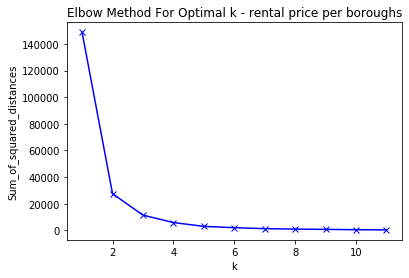

In [77]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - rental price per boroughs')
plt.show()

In [79]:
# set number of clusters
kclusters_b = 2

# run k-means clusterin
kmeans_b = KMeans(n_clusters=kclusters_b, random_state=0,n_init=50,max_iter=500).fit(df_rental_bor)

# check cluster labels generated for each row in the dataframe
kmeans_b.labels_[0:20] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
      dtype=int32)

In [80]:
# add clustering labels
df_rental_bor.insert(0, 'Cluster Labels', kmeans_b.labels_)

# add boroughs latitudes and longitudes
df_rental_bor = pd.merge( df_rental_bor, df_borough[['postal code','latitude','longitude','code insee']], on = 'postal code')
df_rental_bor['latitude'] = df_rental_bor['latitude'].astype('float64')
df_rental_bor['longitude'] = df_rental_bor['longitude'].astype('float64')
df_rental_bor.head()

postal code  Cluster Labels  rental_price   latitude  longitude  code insee
0        75001               1        569.00  48.862563   2.336443       75101
1        75002               1        510.25  48.868279   2.342803       75102
2        75003               1        462.80  48.862872   2.360001       75103
3        75004               1        472.60  48.854341   2.357630       75104
4        75005               1        464.00  48.844443   2.350715       75105

In [81]:
# search cluster number for stations:
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters = k,random_state = 0,n_init = 30,max_iter = 500)
    km = km.fit(df_rental_transport[['rental_price']])
    Sum_of_squared_distances.append(km.inertia_)

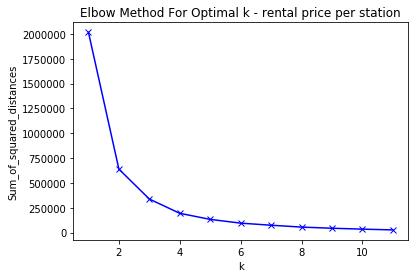

In [82]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - rental price per station')
plt.show()

In [265]:
# set number of clusters
kclusters_r = 2

# run k-means clusterin
kmeans_r = KMeans(n_clusters=kclusters_r, random_state=0,n_init=50,max_iter=500).fit(df_rental_transport[['rental_price']])

# check cluster labels generated for each row in the dataframe
kmeans_r.labels_[0:178] 

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1], dtype=int32)

In [266]:
# add clustering labels
df_rental_transport.insert(0, 'Cluster Labels', kmeans_r.labels_)

df_rental_transport.head()

Cluster Labels    station name  postal code  rental_price  number of lines  \
0               0        Concorde        75001           612                3   
1               0       Argentine        75016           479                1   
2               1       Couronnes        75011           344                1   
3               1  Colonel Fabien        75019           337                1   
4               1     La Chapelle        75010           218                1   

    latitude  longitude  
0  48.866286   2.322943  
1  48.875594   2.289323  
2  48.869091   2.380543  
3  48.877610   2.370811  
4  48.884399   2.360491

In [267]:
#representation of rental price cluster per boroughs and rental price cluster per stations : 
map_clusters_rental = folium.Map(location=[latitudep, longitudep], zoom_start=12)

map_clusters_rental.choropleth(
    geo_data=paris_geo,
    fill_opacity=0.5, 
    line_opacity=0.4,
    data=df_rental_bor,
    columns=['code insee','Cluster Labels'],
    key_on='feature.properties.c_arinsee',
    fill_color='PuBu', 
    legend_name='Cluster mean rental Paris')   

# set color scheme for the clusters
rainbow = ['orange','yellow','red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_rental_transport['latitude'],df_rental_transport['longitude'], df_rental_transport['station name'], df_rental_transport['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(map_clusters_rental)
         
    
map_clusters_rental

In [272]:
print('rental price mean:')
print('Cluster 0 - boroughs (light blue):',
      '  min:', int(round(df_rental_bor[df_rental_bor['Cluster Labels'] ==0].rental_price.min(),0)),'€',
      ' - max:', int(round(df_rental_bor[df_rental_bor['Cluster Labels'] ==0].rental_price.max(),0)),'€')
print('Cluster 1 - boroughs (dark blue):',
      '   min:', int(round(df_rental_bor[df_rental_bor['Cluster Labels'] ==1].rental_price.min(),0)),'€',
      ' - max:', int(round(df_rental_bor[df_rental_bor['Cluster Labels'] ==1].rental_price.max(),0)),'€')


print('\nCluster 0 - station (orange):'
      '       min:', round(df_rental_transport[df_rental_transport['Cluster Labels'] ==0].rental_price.min(),0),'€',
      ' - max:', round(df_rental_transport[df_rental_transport['Cluster Labels'] ==0].rental_price.max(),0),'€')
print('Cluster 1 - station (yellow):',
      '      min:', round(df_rental_transport[df_rental_transport['Cluster Labels'] ==1].rental_price.min(),0),'€',
      ' - max:', round(df_rental_transport[df_rental_transport['Cluster Labels'] ==1].rental_price.max(),0),'€')


rental price mean:
Cluster 0 - boroughs (light blue):   min: 298 €  - max: 385 €
Cluster 1 - boroughs (dark blue):    min: 463 €  - max: 597 €

Cluster 0 - station (orange):       min: 424 €  - max: 763 €
Cluster 1 - station (yellow):       min: 202 €  - max: 420 €


We will give preference to boroughs where the **average rental price for commercial premises** is **the lowest**. This is **Cluster 0** (dark blue). This reduces the choice of boroughs to the following: **75012 to 75015**. 

In [273]:
# restriction of data on target boroughs : 
df_target_station = df_rental_transport[df_rental_transport['postal code'] >= 75012]
df_target_station = df_target_station[df_target_station['postal code'] <= 75015]
df_target_yoga = df_yoga[df_yoga['postal code'] >= 75012]
df_target_yoga = df_target_yoga[df_target_yoga['postal code'] <= 75015]

#addition of yoga studios from adjacent boroughs : 
df_target_yoga = pd.concat([df_target_yoga,df_yoga[df_yoga['postal code'] == 75007]],axis=0)
df_target_yoga = pd.concat([df_target_yoga,df_yoga[df_yoga['postal code'] == 75006]],axis=0)
df_target_yoga = pd.concat([df_target_yoga,df_yoga[df_yoga['postal code'] == 75005]],axis=0)
df_target_yoga = pd.concat([df_target_yoga,df_yoga[df_yoga['postal code'] == 75004]],axis=0)
df_target_yoga = pd.concat([df_target_yoga,df_yoga[df_yoga['postal code'] == 75016]],axis=0)
df_target_yoga = pd.concat([df_target_yoga,df_yoga[df_yoga['postal code'] == 75020]],axis=0)

In [92]:
# new centers for the next maps : 
latitude5 = df_borough.loc[5,'latitude']
longitude5 = df_borough.loc[5,'longitude']

In [323]:
# representation of rental price cluster pro station and yoga studio for target boroughs: 

map_final = folium.Map(location=[latitude5, longitude5], zoom_start=13)

map_final.choropleth(
    geo_data=paris_geo,
    fill_opacity=0.1)   
#paris_map_yoga.add_child(folium.GeoJson(paris_geo))

# set color scheme for the clusters
rainbow = ['orange','yellow','red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,transport in zip(df_target_station ['latitude'],
                                  df_target_station ['longitude'],
                                  df_target_station ['station name'],
                                  df_target_station ['Cluster Labels'],
                                  df_target_station ['number of lines']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '- nb conveyance: ' + str(transport) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_final)
         
for lat, lng, label in zip(df_target_yoga['latitude'],df_target_yoga['longitude'],df_target_yoga['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_final)  
    
map_final

We choosen to keep only the stations of cluster 1 (the lowest rental price). In the aim to take account the transport offer criterion, we only keep the transport stations with more as 1 transport line. 

In [270]:
target_station = df_target_station[df_target_station['Cluster Labels'] ==1]
target_station = target_station[target_station['number of lines']>1]
target_station = target_station.reset_index()
target_station

index  Cluster Labels               station name  postal code  \
0     22               1                    Pasteur        75015   
1     30               1  La Motte Picquet Grenelle        75015   
2     62               1                Porte Dorée        75012   
3     63               1        Porte de Versailles        75015   
4     64               1            Porte d'Orléans        75014   
5     84               1             Place d'Italie        75013   
6     99               1         Porte de Charenton        75012   
7    145               1                    Raspail        75014   
8    167               1                  Daumesnil        75012   

   rental_price  number of lines   latitude  longitude  
0           342                2  48.842921   2.312607  
1           343                3  48.849065   2.297917  
2           311                2  48.834764   2.405349  
3           315                2  48.832601   2.288253  
4           302                2  48.823152   2.325510  
5           389                3  48.830995   2.355835  
6           275                2  48.832305   2.399182  
7           420                2  48.838964   2.330754  
8           336                2  48.839567   2.395953

In [275]:
# representation of transport lines cluster pro station and yoga studio for target boroughs: 

map_final_station = folium.Map(location=[latitude5, longitude5], zoom_start=13)

map_final_station.choropleth(
    geo_data=paris_geo,
    fill_opacity=0.1)   
#paris_map_yoga.add_child(folium.GeoJson(paris_geo))

# set color scheme for the clusters
rainbow = ['blue','purple']

# add markers to the map
markers_colors = []
for lat, lon, poi,transport in zip(target_station['latitude'],
                                  target_station ['longitude'],
                                  target_station ['station name'],
                                  target_station ['number of lines']):
    label = folium.Popup(str(poi) +  '- nb conveyance: ' + str(transport) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[transport-2],
        fill=True,
        fill_color=rainbow[transport-2],
        fill_opacity=0.7).add_to(map_final_station)
         
for lat, lng, label in zip(df_target_yoga['latitude'],df_target_yoga['longitude'],df_target_yoga['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 4,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_final_station)  
    
map_final_station

By choosing the **lowest rental price cluster** and adding the **intermodality criterion**, we obtain 7 stations/sectors.The stations in **orange** are those with **2 transport lines**, in **yellow 3 lines**. The existing **yoga studios** are shown in **green**.  

It can be seen that 4 stations are located on the outskirts of paris and are connected to each other by the same line. 
It would seem more appropriate to concentrate on the **stations located most in the centre of Paris in order to multiply the geographical origins of the customers**. We would therefore advise limiting our choice to the surroundings of the following stations: 

**La Motte Picquet Grenelle** :  
average price/m2/year: 343€, number of transport lines: 3, borough : 75015, weight transport : 4.95, touristic cluster  
**Pasteur** :  
average price/m2/year: 342€, number of transport lines: 2, borough : 75015, weight transport : 4.95, touristic cluster  
**Raspail** :  
average price/m2/year: 420€, number of transport lines: 2, borough : 75014, weight transport : 2.06, touristic cluster  
**Place d'Italie** :  
average price/m2/year: 389€, number of transport lines: 3, borough : 75013, weight transport : 3.56        
**Daumesnil** :  
average price/m2/year: 336€, number of transport lines: 2, borough : 75012, weight transport : 7.23          


## Results and Discussion <a name="results"></a>

Our analysis shows that although there are a number of yoga studios in Paris (~ 176 ), some districts have a small number of them. The highest concentration of yoga studios was detected in the north and east of the centre of Paris. We first tried to understand the reason for this heterogeneity of concentration. We analyzed the profile of the districts according to the most frequent locations according to Foursquare. This showed us that the west of Paris seemed more touristy. Indeed, it has twice as many hotels, an additional third of French restaurants and only a third of the number of bars in eastern Paris. We can therefore assume that the clientele is stronger in the districts where it lives. However, some western districts also have many yoga studios. This is why we cannot use this distinction of boroughs as a selection criterion. However, this profiling of the boroughs can be used as a criterion in the final selection.

We then studied the population profile of the individual boroughs according to criteria related to the number of yoga studios per borough (population aged 30-44, intermediate professions, employees, workers). The study of the profiles of its boroughs associated with the criterion of yoga studio density enabled us to limit the number of target boroughs to 7.
After focusing our attention on these boroughs, we first prepared the transportation data. We analyzed the weight of transport by borough, according to the number of different lines and the presence of hubs (stations with an offer greater than or equal to 3 transport lines). These data will help us to refine the final choice. 

Finally, we have analysed the profiles of the boroughs according to the average annual price per square metre of commercial space rental. Selecting the least expensive one reduced the number of target boroughs to 4. We were then able to refine the search by transport station. By focusing on the cluster of least expensive areas and taking into account the transport line offer (>=2), we obtained 9 interesting areas. In the same logic of transport offers, we propose to eliminate the stations located at the extremities of the city. This will enable us to potentially have a clientele of more varied geographical origin. We then obtain 5 stations, i.e. 5 possible zones. The choice will then be influenced according to the importance given to the different remaining criteria: the proximity of already existing yoga studios and the transport offer.

Of course, this does not mean that these zones are really optimal locations for a new yoga studio! The objective of this analysis was to provide an understanding of the disparity of the number of yoga studios per borough, allowing us to identify interesting boroughs by adding 2 selected criteria. 
It is quite possible that there is a very good reason why these areas have few or no yoga studios, which would make them unsuitable for a new yoga studio, regardless of whether our criteria are met. The recommended areas should therefore only be considered as a starting point for a more detailed analysis which could lead to reasonably expensive, properly serviced location where the alleged client lives, but also where other factors are taken into account and where all other relevant conditions are met.


## Conclusion  <a name="conclusion"></a>

The goal of this project was to identify areas of Paris populated by potential clients in order to help stakeholders narrow down the search for an optimal location for a new yoga studio. By studying the profile of the boroughs based on data on population distribution and density of yoga studios, we first identified the general boroughs that warrant further analysis (75001, 75004, 75012-75015, 75017). Then we grouped the boroughs according to the rental prices of the premises. The superimposition of the different groupings carried out enabled us to reduce the interested boroughs to the 12th, 13th, 14th, and 15th districts.  Taking into account the offer of transport revealed areas of interest at the mesh of the transport station. These areas could serve as a starting point for final exploration by stakeholders.

The final decision on the optimal location of yoga studios will be made by the stakeholders on the basis of the specific characteristics of the districts and the locations in each recommended zone, taking into account additional factors such as competition in the same type of yoga practice, the attractiveness of each location (size of residential population), the proximity of the Vélib station, the availability of real estate, prices, the social and economic dynamics of each zone, etc.